#Toxic Identifyer

Project Background : Model ini digunakan untuk dapat mengidentifikasi tingkat toxic berdasarkan threshold probablility, dengan menggunakan model ML yang tepat maka akan didapatkan peluang kelas positif di setiap kalimat yang diujikan apakah termasuk toxic ataupun termasuk kalimat lain

Install Library

In [18]:
%pip install wordcloud

     ---------------------------------------- 0.0/151.4 kB ? eta -:--:--
     ----------------------------------- -- 143.4/151.4 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 151.4/151.4 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Library

In [1]:
import re
import nltk
import string
import nlp_utils
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [45]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

Load dataset

In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Data info

In [6]:
df.shape

(159571, 8)

In [7]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [9]:
kolom =["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
for i in kolom :
    print(df[i].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


EDA

In [10]:
listtrue = []
for i in kolom:
    listtrue.append(df[i].value_counts()[1])

listfalse = []
for i in kolom:
    listfalse.append(df[i].value_counts()[0])


listtogrup = pd.DataFrame({'Kolom': kolom, 'jumlahtrue': listtrue, 'jumlahfalse': listfalse})


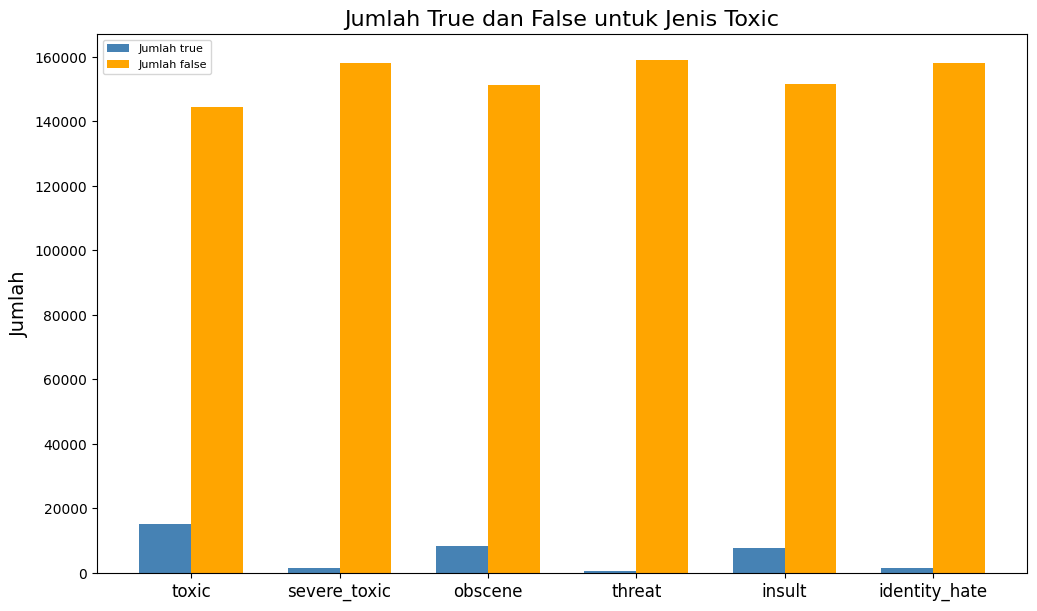

In [11]:
x = np.arange(len(kolom))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

true1 = ax.bar(x - width/2, listtrue, width, label='Jumlah true', color='steelblue')
false1 = ax.bar(x + width/2, listfalse, width, label='Jumlah false', color='orange')

ax.set_title('Jumlah True dan False untuk Jenis Toxic', size=16)
ax.set_ylabel('Jumlah', size=14)
ax.set_xticks(x)
ax.set_xticklabels(kolom, size=12)
ax.legend(fontsize=8,loc="best")

plt.show()

Groupbar chart diatas menunjukkan jumlah true untuk beberapa kategori toxic dan juga jumlah false nya dapat diketahui bahwa jumlah false lebih dominan sehingga sangat tidak balance antar data kategori toxic dan tidak 

Text Preprocessing

In [12]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [13]:
selected_columns = ['id', 'comment_text']

additional_columns = ['toxic','severe_toxic','obscene','threat','insult', 'identity_hate']

dataframes = {}

for col in additional_columns:
    columns_to_select = selected_columns + [col]
    dataframe_name = f"df_{col}" 
    dataframes[dataframe_name] = df.loc[:, columns_to_select]


In [14]:
#save data   
df_toxic = dataframes["df_toxic"]
df_severe_toxic = dataframes["df_severe_toxic"]
df_obscene = dataframes["df_obscene"]
df_threat = dataframes["df_threat"]
df_insult = dataframes["df_insult"]
df_identity_hate = dataframes["df_identity_hate"]



Visualisasi menggunakan wordcloud kata ata yang paling sering muncul

In [15]:
def mapping(df, label):
    
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=2000, colormap="viridis" )

    wc.generate(" ".join(text))

    plt.figure(figsize=(8,10))
    plt.axis("off")
    plt.title("Kata-kata {} yang paling sering muncul".format(label), fontsize=18)
    plt.imshow(wc.recolor(random_state=244), alpha=0.98)

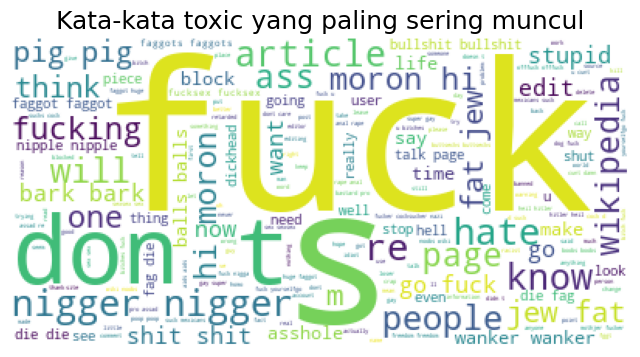

In [16]:

mapping(df_toxic,'toxic')

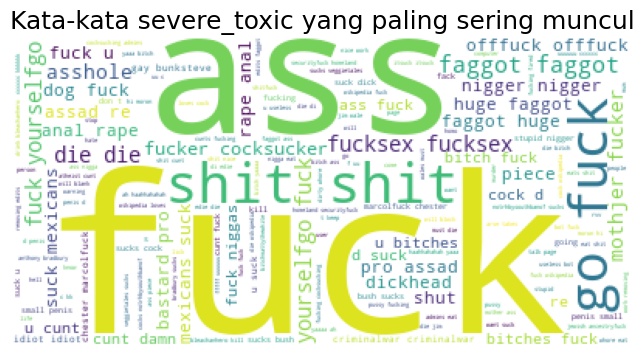

In [61]:
mapping(df_severe_toxic,'severe_toxic')

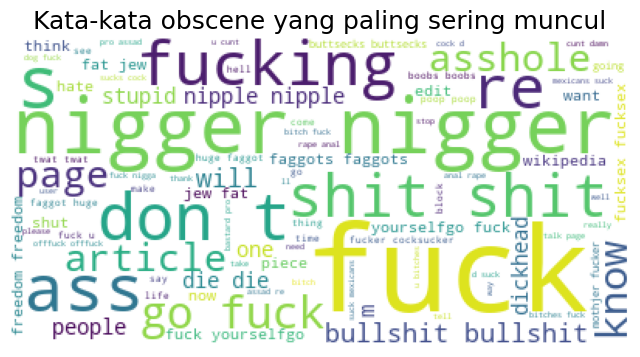

In [53]:
mapping(df_obscene,'obscene')

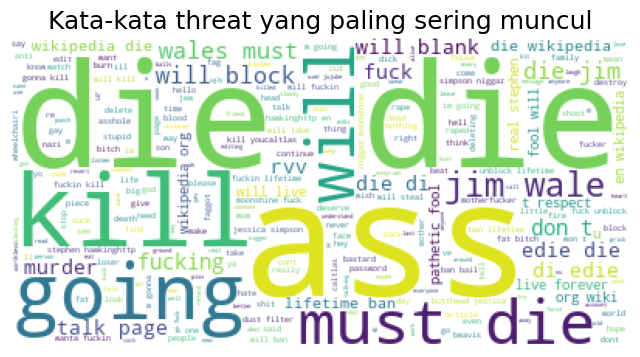

In [54]:
mapping(df_threat,'threat')

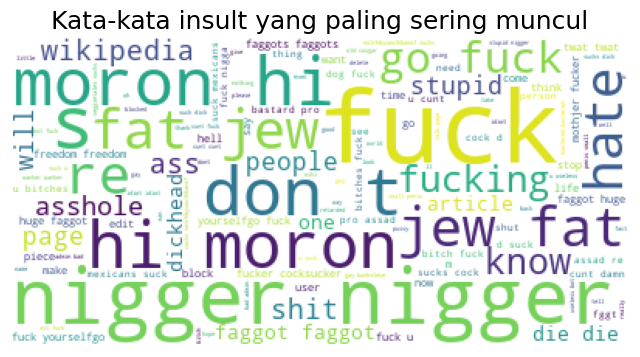

In [56]:
mapping(df_insult,'insult')

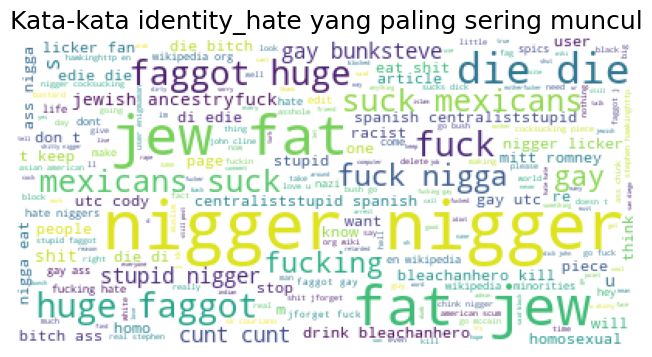

In [63]:
mapping(df_identity_hate,'identity_hate')

Column Balancing 

Column balancing perlu dilakukan untuk membuat data lebih balance sehingga dapat menghasilkan hasil pelatihan yang bagus, balance akan disamakan dengan jumlah kategori toxic paling minimum sehingga didapatkan hasil seimbang antara true dan false

In [17]:

def balance(df, label):
    min_count = df[label].value_counts().min()
    pos_df = df[df[label] == 1].iloc[0:min_count, :]
    neg_df = df[df[label] == 0].iloc[0:min_count, :]
    namet = pd.concat([pos_df,neg_df], ignore_index=True)
    return namet
    #globals()[namadfbaru] = name
    

In [18]:
df_toxic["toxic"].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [19]:
df_toxic_balance = balance(df_toxic,'toxic')
df_toxic_balance["toxic"].value_counts()

1    15294
0    15294
Name: toxic, dtype: int64

In [20]:
df_severe_toxic_balance = balance(df_severe_toxic,'severe_toxic')
df_severe_toxic_balance["severe_toxic"].value_counts()

1    1595
0    1595
Name: severe_toxic, dtype: int64

In [21]:
df_obscene_balance = balance(df_obscene,'obscene')
df_obscene_balance["obscene"].value_counts()

1    8449
0    8449
Name: obscene, dtype: int64

In [22]:
df_threat_balance = balance(df_threat,'threat')
df_threat_balance["threat"].value_counts()

1    478
0    478
Name: threat, dtype: int64

In [23]:
df_insult_balance = balance(df_insult,'insult')
df_insult_balance["insult"].value_counts()

1    7877
0    7877
Name: insult, dtype: int64

In [24]:
df_identity_hate_balance = balance(df_identity_hate,'identity_hate')
df_identity_hate_balance["identity_hate"].value_counts()

1    1405
0    1405
Name: identity_hate, dtype: int64

ML Model

In [25]:
def cv_tf_train_test(dataframe,label):

    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train) 
    X_test_cv1  = cv1.transform(X_test)      
    
    ## Machine learning models   
    
    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    
    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    
    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    
    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest 
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)
    
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
    ## Saving f1 score results into a dataframe                     
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

Disetiap pelatihan data akan dipilih model dengan nilai f1 score paling baik

In [26]:
toxic_cv = cv_tf_train_test(df_toxic_balance, 'toxic')
toxic_cv

,F1 Score
Log Regression,0.882528
KNN,0.673476
BernoulliNB,0.765386
MultinomialNB,0.879875
SVM,0.893607
Random Forest,0.847385


In [27]:

severe_toxic_cv = cv_tf_train_test(df_severe_toxic_balance, 'severe_toxic')
#severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_cv

,F1 Score
Log Regression,0.940282
KNN,0.861407
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [28]:
obscene_cv = cv_tf_train_test(df_obscene_balance, 'obscene')
obscene_cv

,F1 Score
Log Regression,0.916735
KNN,0.227648
BernoulliNB,0.785481
MultinomialNB,0.897783
SVM,0.930288
Random Forest,0.910396


In [29]:
threat_cv = cv_tf_train_test(df_threat_balance, 'threat')
threat_cv

,F1 Score
Log Regression,0.897338
KNN,0.852459
BernoulliNB,0.745205
MultinomialNB,0.902098
SVM,0.894737
Random Forest,0.923077


In [30]:
insult_cv = cv_tf_train_test(df_insult_balance, 'insult')
insult_cv

,F1 Score
Log Regression,0.905800
KNN,0.292940
BernoulliNB,0.790283
MultinomialNB,0.902316
SVM,0.913322
Random Forest,0.894402


In [31]:
identity_hate_cv = cv_tf_train_test(df_identity_hate_balance, 'identity_hate')
identity_hate_cv

,F1 Score
Log Regression,0.905707
KNN,0.820046
BernoulliNB,0.776699
MultinomialNB,0.903302
SVM,0.896806
Random Forest,0.888087


In [70]:
X = df_toxic_balance.comment_text
y = df_toxic_balance['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
modelsvm3 = LinearSVC(random_state=42)

modelsvm3.fit(X_train_fit, y_train)
modelsvm3.predict(X_test_fit)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [71]:
svm = LinearSVC()

# Inisialisasi CalibratedClassifierCV dengan menggunakan metode sigmoid (Platt Scaling)
clf = CalibratedClassifierCV(svm, method='sigmoid')

# Melatih model pada data pelatihan
clf.fit(X_train_fit, y_train)

# Membuat prediksi probabilitas
comment = ['nigger poor']
comment_vect = tfv.transform(comment)
probs = clf.predict_proba(comment_vect)[:,1]
probs

array([0.99952349])

Menggunakan model svc untuk kategori toxic perkataan "nigger poor" 99.95% positif toxic

In [73]:
X = df_severe_toxic_balance.comment_text
y = df_severe_toxic_balance['severe_toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
Rdm = RandomForestClassifier(n_estimators=100, random_state=50)

Rdm.fit(X_train_fit, y_train)
Rdm.predict(X_test_fit)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,

In [74]:
comment2 = ['good']
comment2_vect = tfv.transform(comment2)
Rdm.predict_proba(comment2_vect)[:,1]

array([0.18])

Koment diatas menjadi salah satu komentar yang baik

In [44]:
X = df_obscene_balance.comment_text
y = df_obscene_balance['obscene']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
modelsvm = LinearSVC(random_state=42)
modelsvm.fit(X_train_fit, y_train)
modelsvm.predict(X_test_fit)

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [55]:
svm = LinearSVC()

# Inisialisasi CalibratedClassifierCV dengan menggunakan metode sigmoid (Platt Scaling)
clf = CalibratedClassifierCV(svm, method='sigmoid')

# Melatih model pada data pelatihan
clf.fit(X_train_fit, y_train)

# Membuat prediksi probabilitas
comment3 = ['cocksucker']
comment3_vect = tfv.transform(comment3)
probs = clf.predict_proba(comment3_vect)[:,1]
probs

array([0.98128935])

komentar cocksucker 98.12% positif kata-kata yang obscene

In [56]:
X = df_threat_balance.comment_text
y = df_threat_balance['threat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
modelrdf = RandomForestClassifier(n_estimators=100,random_state=42)
modelrdf.fit(X_train_fit, y_train)
modelrdf.predict(X_test_fit)

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1], dtype=int64)

In [61]:
comment4 = ['kill bomb fuck you']
comment4_vect = tfv.transform(comment4)
modelrdf.predict_proba(comment4_vect)[:,1]

array([0.86])

Koment diatas termasuk kedalam positif dari kata-kata ancaman

In [62]:
X = df_insult_balance.comment_text
y = df_insult_balance['insult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
modelsvm2 = LinearSVC(random_state=42)
modelsvm2.fit(X_train_fit, y_train)
modelsvm2.predict(X_test_fit)

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [64]:
svm = LinearSVC()

# Inisialisasi CalibratedClassifierCV dengan menggunakan metode sigmoid (Platt Scaling)
clf = CalibratedClassifierCV(svm, method='sigmoid')

# Melatih model pada data pelatihan
clf.fit(X_train_fit, y_train)

# Membuat prediksi probabilitas
comment3 = ['nigger poor']
comment3_vect = tfv.transform(comment3)
probs = clf.predict_proba(comment3_vect)[:,1]
probs

array([0.99780283])

Kembali lagi kata-kata nigger poor termasuk kedalam kalimat insult

In [66]:
X = df_identity_hate_balance.comment_text
y = df_identity_hate_balance['identity_hate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
modellogreg1 = LogisticRegression(random_state=42)
modellogreg1.fit(X_train_fit, y_train)
modellogreg1.predict(X_test_fit)

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,

In [69]:
comment5 = ['why are you stupid']
comment5_vect = tfv.transform(comment5)
modellogreg1.predict_proba(comment5_vect)[:,1]

array([0.75371863])

stupid menjadi komen yang merujuk pada penghinaan 

Kesimpulan yang diapat dari model Ml yang telah dikembangkan sudah mampu mengidentifikasi kata-kata dengan kategori toxic sesuai dengan ambang batas probability kelas positif